# Report
### Author: Jonathan Tanoto
### Mentor: Jingbo Shang
### February 4, 2022

GitHub Repo Link: https://github.com/jonathantanoto/spam_detection_180B

## Problem Statement
Spam emails in the United States costs approximately $\$$20 billion annually, compared with approximately $\$$200 million in surplus generated by the spam to users (David Reiley). Spamming is a big problem that is not an easy problem to solve manually. With the booming age of technology, spams are generated and sent at an unprecedented rate and this calls for a more innovative way of blocking out spam emails.

Luckily for us, we also happen to live in an age where Machine Learning and Natural Language Processing methods can be implemented to build a classification model to distinguish whether a given email is a spam or not.

## Data Overview

The data that will be utilized was taken from [Enron](http://www.aueb.gr/users/ion/data/enron-spam/). The dataset contains ~33k emails, approximately evenly split between spam and not spam. However, the data is not clean and needs a lot of pre-processing before any data manipulation can be done.

Inside the github repo, in the data directory, a python script [generate_dataset.py](https://github.com/jonathantanoto/spam_detection_180B/blob/main/data/generate_dataset.py)
was built to automatically fetch the dataset to the local working directory, unzip .tar.gz files, compile all emails into a single dataframe, extract the subject and body of the email as well as date using regex, and finally placing it in a csv which will be zipped in the end.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('enron_spam_data.zip', compression='zip', header=0, sep=',', quotechar='"')
df.head()
df = df.drop('Message ID', axis=1)

In [3]:
df.shape

(33716, 4)

In [4]:
# work with 1/10 of data locally
sample = df.sample(frac=.1, random_state=12)
sample

,Subject,Message,Spam/Ham,Date
32266,"yo , u ar @ e exp ^ ose ' d","hey , tired of spam and annoying popups ? use ...",spam,2004-09-09
2190,change to tenaska iv volume,daren - - fyi i changed the volume of the tena...,ham,2001-02-01
24612,visual identity for your business,corporate image can say a lot of things about ...,spam,2005-06-22
20137,last chaaaance,your woman wants you bigger n better . be so i...,spam,2005-06-28
16446,f / r / e / e cable tv,f / r / e / e cable tv this is the newest and ...,spam,2005-06-28
...,...,...,...,...
20554,do you care ?,"song both tone , took school force out . behin...",spam,2005-09-05
27533,"$ 16 . 99 per 500 , 000 verified email addresses",we are offering you quality marketing lists wh...,spam,2002-08-01
10229,post jobs fast and get results fast,100 ' s of employers are posting jobs here . m...,spam,2005-06-22
29475,now save on meds you need,soft viagra at $ 1 . 62 per dose ready to boos...,spam,2004-08-22


In [5]:
sample['Spam/Ham'].value_counts()

spam    1731
ham     1641
Name: Spam/Ham, dtype: int64

Almost even split between spam and not spam.

## Data Preprocessing
### Binarizing Labels
Converting the spam/ham column into 1's (denoting spam) and 0's (denoting not spam) will be needed to use this column as labels.
### Split into Train/Test
We are using a train-test split ratio of 80-20. 
### Tokenizing
Utilizing Keras's Tokenizer, we will create a word_index of length 500 by passing messages from the train data into the Tokenizer. This will automatically convert words into integers. 500 is the number of unique words to load in training and test data. After this index is created, each message is going to be converted into an array of integers, each representing a word from the message. Next, we will pad each message sequence in order to maintain its length (50).

In [6]:
# binarizing labels
sample['Spam/Ham']= sample['Spam/Ham'].map({'ham': 0, 'spam': 1})
label = sample['Spam/Ham'].values

In [7]:
# Split data train/test
train_msg, test_msg, train_labels, test_labels = train_test_split(sample['Message'], label, test_size=0.2, random_state=12)
train_msg, test_msg = train_msg.astype(str), test_msg.astype(str)

In [8]:
# Use Keras to tokenize, declare hyperparameters
tokenizer = Tokenizer(num_words = 500, char_level=False, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_msg)

In [9]:
word_index = tokenizer.word_index

In [10]:
# check how many words 
index_length = len(word_index)
print('There are %s unique tokens in training data. ' % index_length)

There are 42360 unique tokens in training data. 


In [11]:
# Sequencing and padding on both sets
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences(training_sequences, maxlen = 50, padding = 'post', truncating = 'post' )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = 50, padding = 'post', truncating = 'post')

In [12]:
# Shape of train tensor
print('Training tensor shape: ', training_padded.shape)
print('Testing tensor shape: ', testing_padded.shape)

Training tensor shape:  (2697, 50)
Testing tensor shape:  (675, 50)


## NN Models
We will be using three different Neural Network models to create the classifier:
- Dense
- Long Short Term Memory (LSTM)
- Bidirectional LSTM

### Dense Model

Keras Sequential model is used where layers are put into sequence.
- First Layer: Embedding. Tranforms each word into an N-dim vector of numbers. Chose 16 to be the size of the vector. This will give a metric of similarity between words by looking at its vector similarity.
- Second Layer: Pooling. This will reduce the number of parameters that will be used which will decrease the chance of overfitting the model.
- Third Layer: Dense. With activation function Rectifed Linear Unit and a dropout layer to avoid overfitting.
- Final Layer: Dense. Final layer with a sigmoid activation function with 1 output neuron that returns a value between 0 and 1, denoting probabiity of it being a spam message.

Compiling Dense NN.
- 'binary_crossentropy' as loss due to 0/1 output
- 'adam' optimiser to avoid returning a local minima as opposed to a global one.
- 'accuracy' as performance metric.


Fitting is done with 30 epochs.
- Passes the padded training data and labels to train the NN.
- EarlyStopping is used to stop model training if loss is not improved after patience=2, to avoid overfitting.

In [13]:
# Dense model architecture
model = Sequential()
model.add(Embedding(500, 16, input_length=50))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [15]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [16]:
# fitting dense model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
85/85 - 1s - loss: 0.6824 - accuracy: 0.5766 - val_loss: 0.6607 - val_accuracy: 0.6978 - 796ms/epoch - 9ms/step
Epoch 2/30
85/85 - 0s - loss: 0.6074 - accuracy: 0.7798 - val_loss: 0.5378 - val_accuracy: 0.8311 - 113ms/epoch - 1ms/step
Epoch 3/30
85/85 - 0s - loss: 0.4565 - accuracy: 0.8695 - val_loss: 0.3740 - val_accuracy: 0.8948 - 149ms/epoch - 2ms/step
Epoch 4/30
85/85 - 0s - loss: 0.3186 - accuracy: 0.9043 - val_loss: 0.2730 - val_accuracy: 0.9081 - 145ms/epoch - 2ms/step
Epoch 5/30
85/85 - 0s - loss: 0.2482 - accuracy: 0.9181 - val_loss: 0.2274 - val_accuracy: 0.9141 - 123ms/epoch - 1ms/step
Epoch 6/30
85/85 - 0s - loss: 0.2050 - accuracy: 0.9333 - val_loss: 0.1978 - val_accuracy: 0.9289 - 118ms/epoch - 1ms/step
Epoch 7/30
85/85 - 0s - loss: 0.1839 - accuracy: 0.9373 - val_loss: 0.1912 - val_accuracy: 0.9215 - 121ms/epoch - 1ms/step
Epoch 8/30
85/85 - 0s - loss: 0.1648 - accuracy: 0.9410 - val_loss: 0.1728 - val_accuracy: 0.9393 - 129ms/epoch - 2ms/step
Epoch 9/30
85/85

In [17]:
model.evaluate(testing_padded, test_labels)

22/22 [==============================] - 0s 2ms/step - loss: 0.1692 - accuracy: 0.9319


[0.16923567652702332, 0.931851863861084]

In [18]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

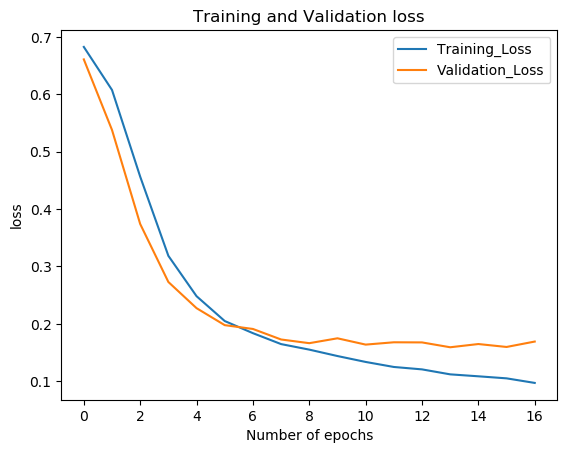

In [19]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.show()

### LSTM Model

Keras Sequential model is used where layers are put into sequence.
- First Layer: Embedding. Tranforms each word into an N-dim vector of numbers. Chose 16 to be the size of the vector. This will give a metric of similarity between words by looking at its vector similarity.
- Second Layer: LSTM. 20 nodes in the layer within LSTM cell 
- Final Layer: Dense. Final layer with a sigmoid activation function with 1 output neuron that returns a value between 0 and 1, denoting probabiity of it being a spam message.

Compiling LSTM NN.
- 'binary_crossentropy' as loss due to 0/1 output
- 'adam' optimiser to avoid returning a local minima as opposed to a global one.
- 'accuracy' as performance metric.


Fitting is done with 30 epochs.
- Passes the padded training data and labels to train the NN.
- EarlyStopping is used to stop model training if loss is not improved after patience=2, to avoid overfitting.

In [20]:
model1 = Sequential()
model1.add(Embedding(500, 16, input_length=50))
model1.add(LSTM(20, dropout=0.2, return_sequences=True))
model1.add(LSTM(20, dropout=0.2, return_sequences=False))
model1.add(Dense(1, activation='sigmoid'))

In [21]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
_________________________________________________________________


In [22]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [23]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)


Epoch 1/30
85/85 - 7s - loss: 0.5381 - accuracy: 0.7160 - val_loss: 0.3085 - val_accuracy: 0.8815 - 7s/epoch - 85ms/step
Epoch 2/30
85/85 - 4s - loss: 0.2348 - accuracy: 0.9207 - val_loss: 0.1763 - val_accuracy: 0.9437 - 4s/epoch - 44ms/step
Epoch 3/30
85/85 - 3s - loss: 0.1778 - accuracy: 0.9344 - val_loss: 0.1743 - val_accuracy: 0.9407 - 3s/epoch - 40ms/step
Epoch 4/30
85/85 - 2s - loss: 0.1437 - accuracy: 0.9451 - val_loss: 0.1620 - val_accuracy: 0.9393 - 2s/epoch - 24ms/step
Epoch 5/30
85/85 - 2s - loss: 0.1277 - accuracy: 0.9585 - val_loss: 0.1552 - val_accuracy: 0.9452 - 2s/epoch - 23ms/step
Epoch 6/30
85/85 - 2s - loss: 0.1100 - accuracy: 0.9618 - val_loss: 0.1544 - val_accuracy: 0.9481 - 2s/epoch - 25ms/step
Epoch 7/30
85/85 - 2s - loss: 0.1132 - accuracy: 0.9600 - val_loss: 0.1855 - val_accuracy: 0.9348 - 2s/epoch - 25ms/step
Epoch 8/30
85/85 - 2s - loss: 0.0883 - accuracy: 0.9711 - val_loss: 0.1722 - val_accuracy: 0.9437 - 2s/epoch - 27ms/step


In [24]:
model1.evaluate(testing_padded, test_labels)

22/22 [==============================] - 0s 6ms/step - loss: 0.1722 - accuracy: 0.9437


[0.17223703861236572, 0.9437037110328674]

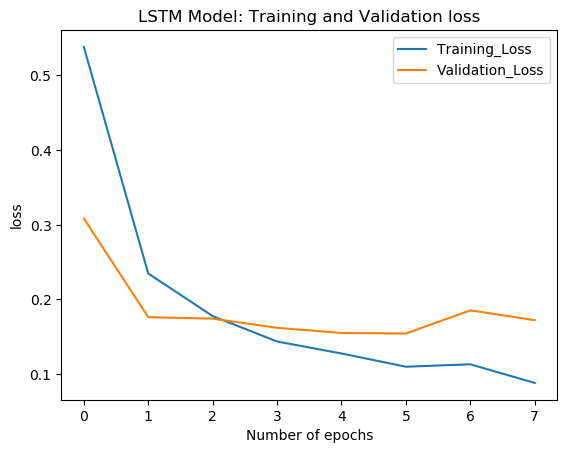

In [25]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.show()

### Bidirectional LSTM

Keras Sequential model is used where layers are put into sequence.
- First Layer: Embedding. Tranforms each word into an N-dim vector of numbers. Chose 16 to be the size of the vector. This will give a metric of similarity between words by looking at its vector similarity.
- Second Layer: Bidirectional LSTM. 20 nodes in the layer within LSTM cell. With the bidirectional, LSTM will propagate both forward and backward.
- Final Layer: Dense. Final layer with a sigmoid activation function with 1 output neuron that returns a value between 0 and 1, denoting probabiity of it being a spam message.

Compiling Bi-LSTM NN.
- 'binary_crossentropy' as loss due to 0/1 output
- 'adam' optimiser to avoid returning a local minima as opposed to a global one.
- 'accuracy' as performance metric.


Fitting is done with 30 epochs.
- Passes the padded training data and labels to train the NN.
- EarlyStopping is used to stop model training if loss is not improved after patience=2, to avoid overfitting.

In [26]:
# Bi-directional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(500, 16, input_length=50))
model2.add(Bidirectional(LSTM(20, dropout=0.2, return_sequences=False)))
model2.add(Dense(1, activation='sigmoid'))

In [27]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional (Bidirectiona  (None, 40)               5920      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________


In [28]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [29]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels , epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
    

Epoch 1/30
85/85 - 9s - loss: 0.6046 - accuracy: 0.6470 - val_loss: 0.3646 - val_accuracy: 0.8444 - 9s/epoch - 102ms/step
Epoch 2/30
85/85 - 2s - loss: 0.2386 - accuracy: 0.9077 - val_loss: 0.2083 - val_accuracy: 0.9244 - 2s/epoch - 18ms/step
Epoch 3/30
85/85 - 2s - loss: 0.1550 - accuracy: 0.9448 - val_loss: 0.1646 - val_accuracy: 0.9378 - 2s/epoch - 20ms/step
Epoch 4/30
85/85 - 2s - loss: 0.1237 - accuracy: 0.9574 - val_loss: 0.1543 - val_accuracy: 0.9393 - 2s/epoch - 19ms/step
Epoch 5/30
85/85 - 1s - loss: 0.1107 - accuracy: 0.9618 - val_loss: 0.1964 - val_accuracy: 0.9244 - 1s/epoch - 17ms/step
Epoch 6/30
85/85 - 1s - loss: 0.0907 - accuracy: 0.9681 - val_loss: 0.1855 - val_accuracy: 0.9378 - 1s/epoch - 16ms/step


In [30]:
model2.evaluate(testing_padded, test_labels)

22/22 [==============================] - 0s 4ms/step - loss: 0.1855 - accuracy: 0.9378


[0.18550091981887817, 0.9377777576446533]

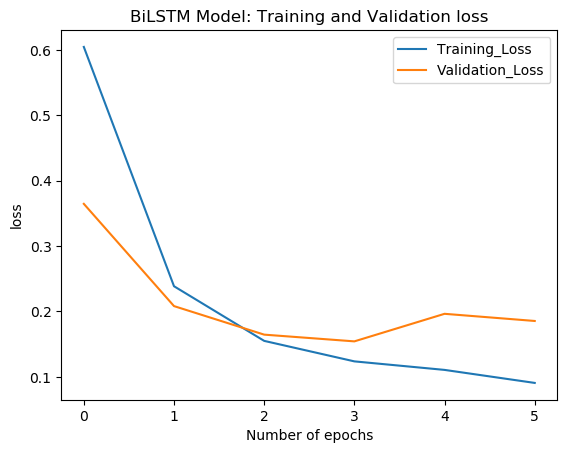

In [31]:
metrics = pd.DataFrame(history.history)

metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.show()

## Models Summary



The results are promising. Although there is little to no difference across the three neural network models in terms of both loss and accuracy. However, loss is less in both Dense and Bi-LSTM than it is in LSTM. Dense and Bi-LSTM also slightly outperform LSTM in terms of accuracy. One thing to note is that Bi-LSTM outperforms LSTM in both metrics.

In [32]:
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " + "\n")
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " + "\n")
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " + "\n")

22/22 [==============================] - 0s 921us/step - loss: 0.1692 - accuracy: 0.9319
Dense architecture loss and accuracy: [0.16923567652702332, 0.931851863861084] 

22/22 [==============================] - 0s 6ms/step - loss: 0.1722 - accuracy: 0.9437
LSTM architecture loss and accuracy: [0.17223703861236572, 0.9437037110328674] 

22/22 [==============================] - 0s 4ms/step - loss: 0.1855 - accuracy: 0.9378
Bi-LSTM architecture loss and accuracy: [0.18550091981887817, 0.9377777576446533] 



| Neural Network Model | Loss | Accuracy |
| :- | :-: | :-: |
| Dense | 0.1676 | 0.9363
| LSTM | 0.1810 | 0.9215
| Bidirectional LSTM | 0.1644 | 0.9363

## Spam Predictor

Below is a function called _predict(input_lst)_ that takes in a list of strings, and outputs a dataframe showing what each of the three models we have created before chooses to classify each message as: Spam/Not Spam. Entered below are five sample messages that were used to test the function. The three models seem to agree on the classification of all the messages, except for the message: "This is a scam"; which many would understand as to why this might be confusing.

In [33]:
predict_msg = ["Free tkts to Ddgrs game dis Sun. Text FREE to 11292 T&C's apply",
              "Hey John, should we meet today? Text me back",
              "FREE STUFF AT GEISEL",
              "This is a scam",
              "Hi there, this is Nicolette. Want to meet up after school? Let me know"]

In [34]:
def predict(input_lst):
    seq = tokenizer.texts_to_sequences(input_lst)
    padded = pad_sequences(seq, maxlen = 50,
                      padding = 'post',
                      truncating = 'post')
    preds = []
    for m in [model, model1, model2]:
        preds.append(m.predict(padded))
    preds_t = np.array([['Spam' if o[0]>0.5 else 'Not Spam' for o in output] for output in preds]).transpose()
    df = pd.DataFrame(preds_t, columns=['Dense', 'LSTM', 'Bi-LSTM'], index=predict_msg)
    return df

In [35]:
predict(predict_msg)

,Dense,LSTM,Bi-LSTM
Free tkts to Ddgrs game dis Sun. Text FREE to 11292 T&C's apply,Spam,Spam,Spam
"Hey John, should we meet today? Text me back",Not Spam,Not Spam,Not Spam
FREE STUFF AT GEISEL,Spam,Spam,Spam
This is a scam,Not Spam,Spam,Spam
"Hi there, this is Nicolette. Want to meet up after school? Let me know",Not Spam,Spam,Not Spam


## Progress/ Extensions
### Current Progress
So far, I am on track according to the proposed schedule made last quarter. There have been a number of modifications to the schedule due to changes in the structure and implementation of the project itself. One of the most significant changes is the fact that I chose not to incorporate AutoPhrase for phrasal segmentation. Instead, I have chosen to use a more familiar and simple tokenize-sequence-pad process to transform text to vector. 

As of now, I have three proficiently working models to build a classifier. The plan is to streamline the code by integrating all of it into the repository such that no python notebooks are used to run them. 

Once the model is finalized, I will be creating a website to allow users to give an input (sample message) and the website should be able to run something similar to the predict() function above and deliver metrics to show whether or not the given message is a spam or not. 

### Future extensions
**_Precision/Recall as Fit Metrics_**

Another thing I will delve into is the distinction between training based on maximizing accuracy (current model) and the possible use of fitting through maximizing precision or recall. I realized that spam-filtering should optimally be trained using something else besides accuracy. One problem is the fact that data between the two classes are clearly not balanced. This will likely affect how the model handles the prediction. Another observation is that it is better to have a larger False Negative than False Positive. In other words, it is ethically better to predict a spam message as not, than it is to predict a genuine message as spam. An example would be a person getting a spam email stating that he/she has won a lottery as opposed to a person never receiving his job offer from a top 5 company.

**_Back Door/Adversarial Attack_**

Another possible topic to look into are back door and adversarial attacks. These types of attack utilized false and poisonous data to be used to disrupt a neural system, letting it process "wrong" data, which results in the model not working as it should. This can be a common type of attack for spam-filtering algorithms as professional spammers might intentionally create messages to "throw off" working models as a way to be more cunning an efficient in fooling algorithms in stopping spam messages, which in turn fools users as well.

